In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow as tf
import zipfile
import pathlib
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = "/content/pca.zip"
extracted_dir_path = "/content/photo"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
data_dir = pathlib.Path("/content/photo/pca")
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
file_list = os.listdir(data_dir)
print(file_list)

['Pants', 'Shoes', 'Shirts', 'Dresses', 'Tshirts', 'Outerwear', 'Shorts', 'Socks', '.DS_Store', 'Underwear', 'Skirts']


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

310


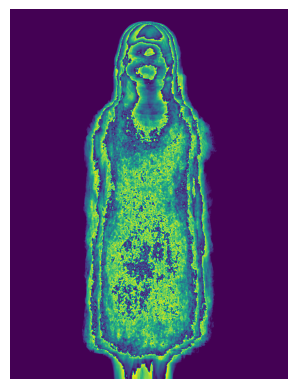

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/photos/pca/dresses/Dresses1.jpeg'  # Replace this with the actual path to an image
try:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for clarity
    plt.show()  # Display the image using Matplotlib
except Exception as e:
    print(f"Error opening image: {e}")

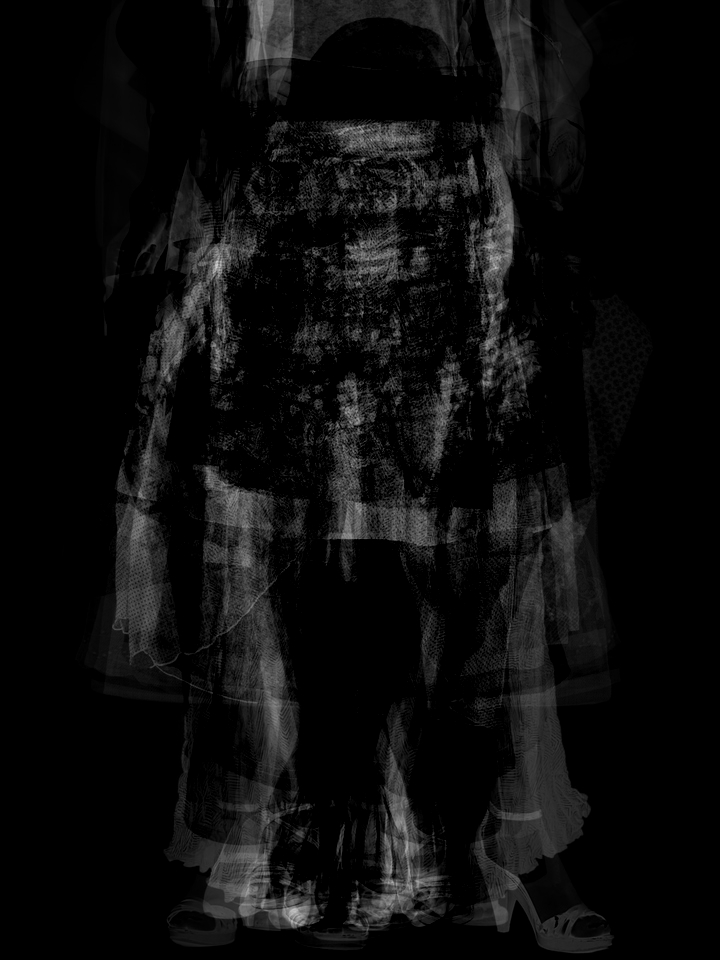

In [ ]:
skirts = list(data_dir.glob('Skirts/*'))
PIL.Image.open(str(skirts[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 310 files belonging to 10 classes.
Using 248 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 310 files belonging to 10 classes.
Using 62 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Dresses', 'Outerwear', 'Pants', 'Shirts', 'Shoes', 'Shorts', 'Skirts', 'Socks', 'Tshirts', 'Underwear']


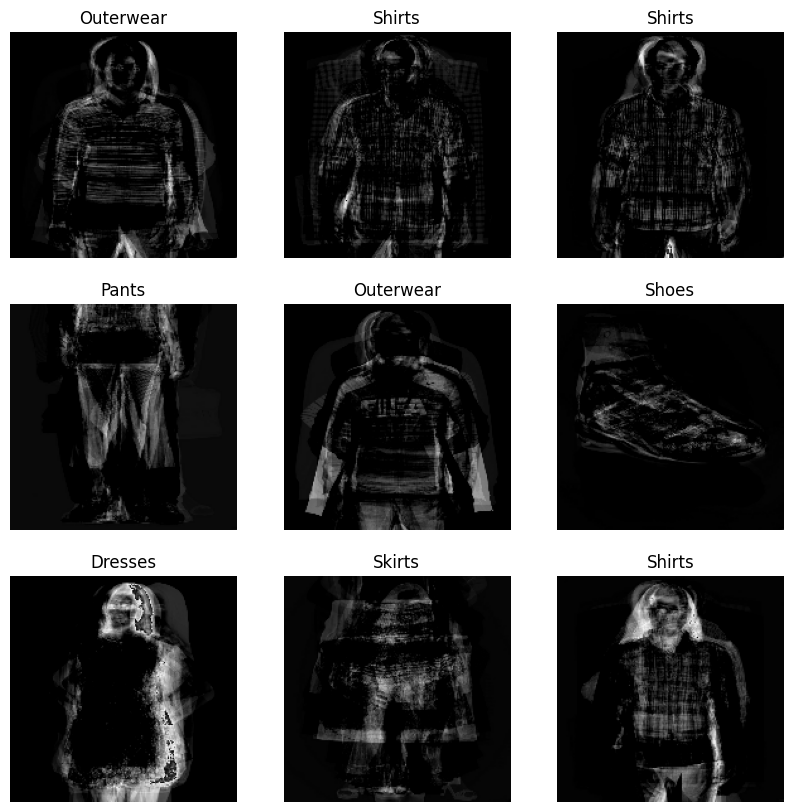

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8258208


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs= 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 2.0267 - accuracy: 0.4113 - val_loss: 1.3651 - val_accuracy: 0.6613
Epoch 2/10
8/8 [==============================] - 8s 953ms/step - loss: 0.8171 - accuracy: 0.7944 - val_loss: 1.0937 - val_accuracy: 0.6774
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.3163 - accuracy: 0.9032 - val_loss: 0.7686 - val_accuracy: 0.8065
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.0800 - accuracy: 0.9839 - val_loss: 0.7673 - val_accuracy: 0.8226
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.4983 - val_accuracy: 0.8387
Epoch 6/10
8/8 [==============================] - 8s 936ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.5588 - val_accuracy: 0.8710
Epoch 7/10
8/8 [==============================] - 10s 1s/step - loss: 7.5188e-04 - accuracy: 1.0000 - val_loss: 0.6916 - val_accuracy: 0.8710
Epoch 8/10
8/8 [=============

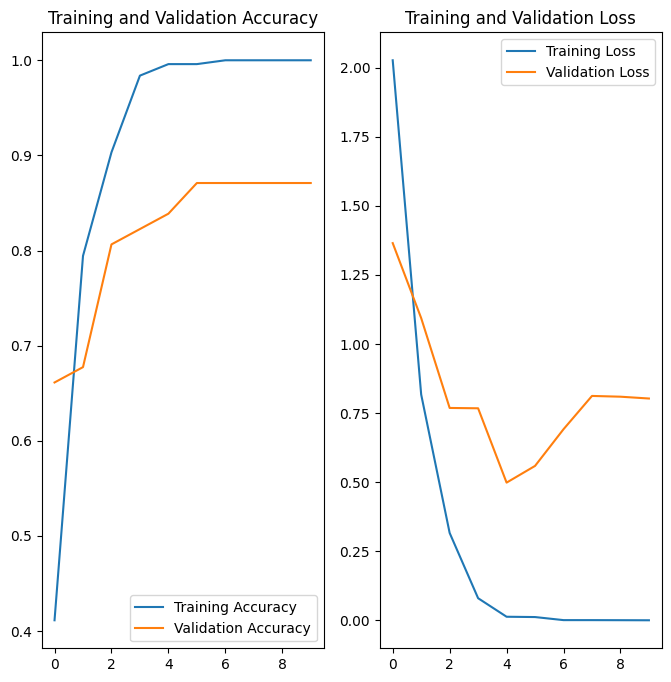

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
shirt = "/content/shirtgs.png"
img = tf.keras.utils.load_img(
    shirt, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 150ms/step
This image most likely belongs to Underwear with a 96.80 percent confidence.


In [ ]:
jean = "/content/jeangs.png"
img = tf.keras.utils.load_img(
    jean, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Tshirts with a 99.90 percent confidence.


In [ ]:
jacket = "/content/jacketgs.png"
img = tf.keras.utils.load_img(
    jacket, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to Underwear with a 98.65 percent confidence.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

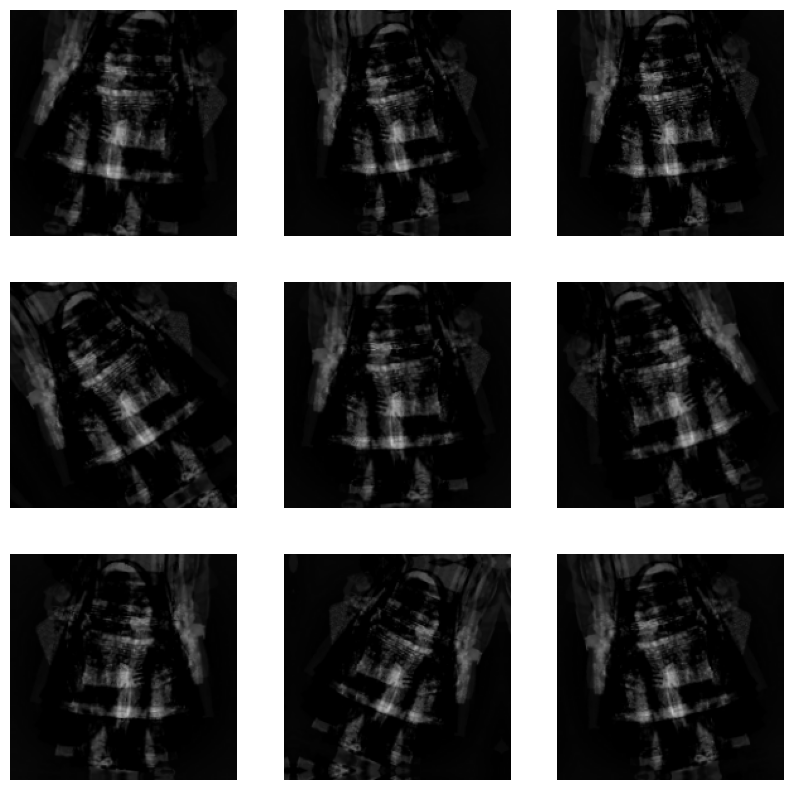

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
8/8 [==============================] - 14s 1s/step - loss: 2.2282 - accuracy: 0.1694 - val_loss: 1.9323 - val_accuracy: 0.3548
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 1.8924 - accuracy: 0.4032 - val_loss: 1.7996 - val_accuracy: 0.3387
Epoch 3/15
8/8 [==============================] - 17s 2s/step - loss: 1.5125 - accuracy: 0.5403 - val_loss: 1.2470 - val_accuracy: 0.6290
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 1.2963 - accuracy: 0.5645 - val_loss: 1.3799 - val_accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 10s 1s/step - loss: 1.1614 - accuracy: 0.5927 - val_loss: 0.9672 - val_accuracy: 0.7258
Epoch 6/15
8/8 [==============================] - 11s 1s/step - loss: 0.9197 - accuracy: 0.7177 - val_loss: 1.2874 - val_accuracy: 0.6290
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.7826 - accuracy: 0.7097 - val_loss: 1.3334 - val_accuracy: 0.5806
Epoch 8/15
8/8 [===================

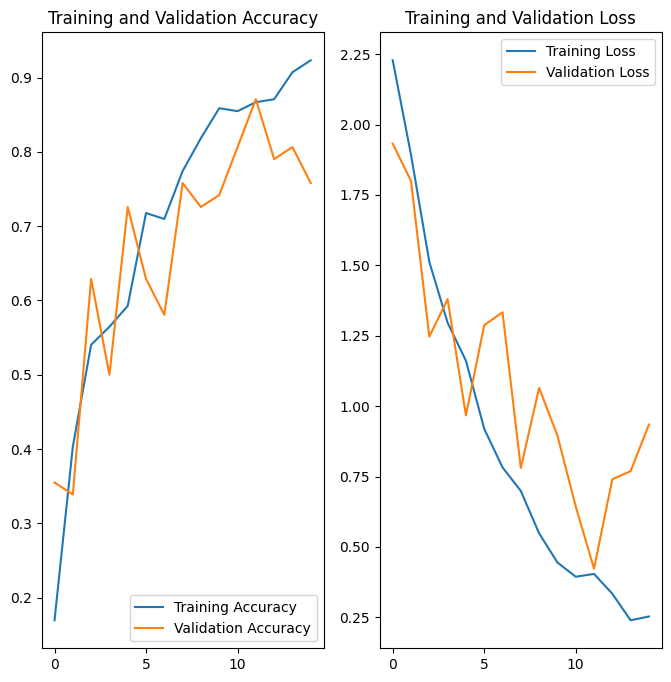

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
shirt = "/content/shirtgs.png"
img = tf.keras.utils.load_img(
    shirt, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 100ms/step
This image most likely belongs to Underwear with a 99.84 percent confidence.


In [ ]:
jean = "/content/jeangs.png"
img = tf.keras.utils.load_img(
    jean, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 39ms/step
This image most likely belongs to Shirts with a 99.12 percent confidence.


In [ ]:
jacket = "/content/jacketgs.png"
img = tf.keras.utils.load_img(
    jacket, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to Shirts with a 94.89 percent confidence.
